In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.api as sm
from scipy.special import inv_boxcox
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('output_file.csv')
df.head()

df.info()

# Project Description:

Analyze the Central African Republic Exports time series. The given data set contains 9 variable. Focus on the Exports variable. It is a time series whose sample size is n = 58. It is the yearly Central African Republic Exports time series from 1960 to 2017.

You should write a concise report summarizing your analysis. The report should be no longer than three (typed) pages, not counting any R output, graphs, etc., which you may wish to include as support or illustration for your analysis. The style of the report is up to you, but the best reports will address many of the questions and details studied in class when we discussed the relevant type of analysis using the ARIMA model.

# Plot Original 'Exports' Data With Trend Line

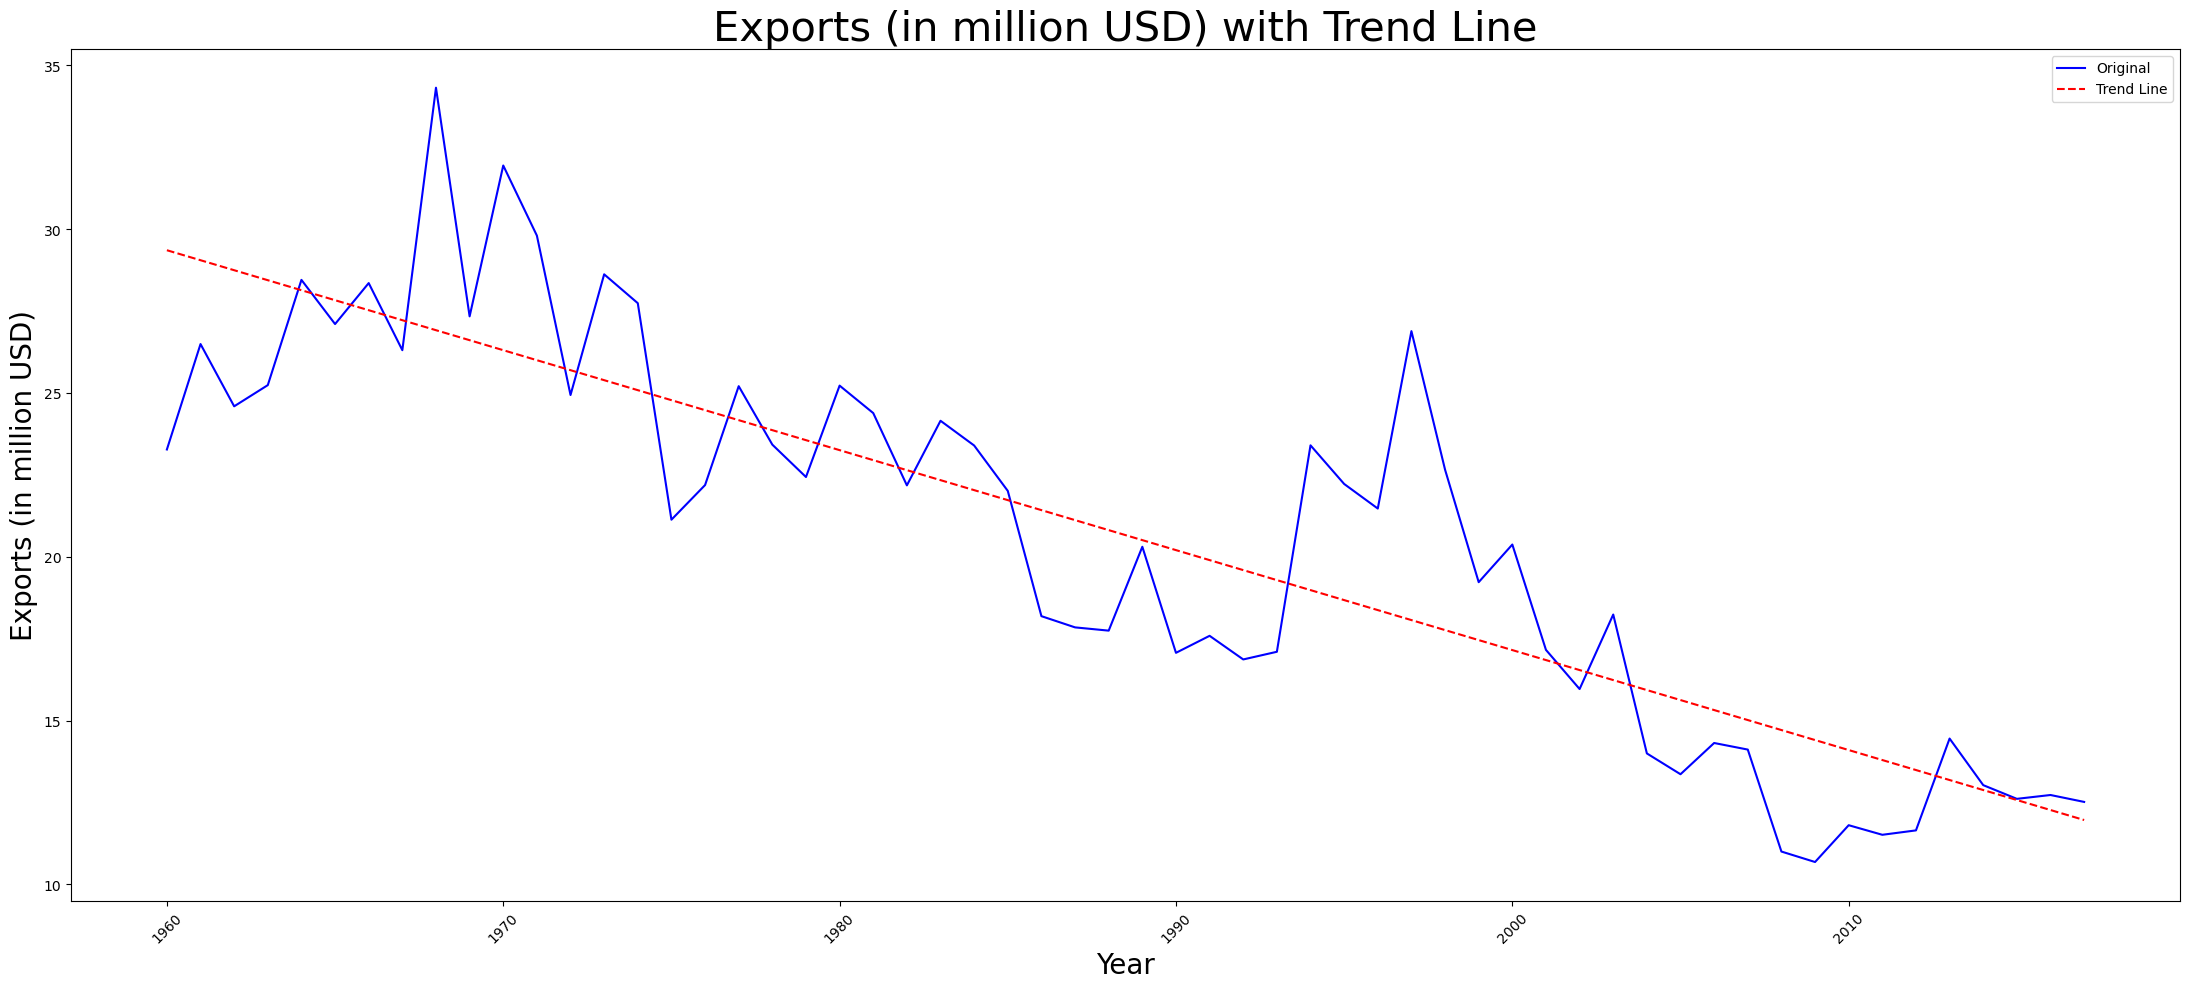

count    58.000000
mean     20.659461
std       5.940139
min      10.684417
25%      16.188454
50%      21.739453
75%      25.136998
max      34.312298
Name: Exports, dtype: float64

In [5]:
plt.figure(figsize=(22, 10))
plt.plot(df['Year'], df['Exports'], color='blue', label='Original')

z = np.polyfit(df['Year'], df['Exports'], deg=1)
p = np.poly1d(z)
plt.plot(df['Year'], p(df['Year']), "r--", label='Trend Line')  
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Exports (in million USD)',fontsize = 20)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Exports (in million USD) with Trend Line',fontsize = 30)
plt.tight_layout()
plt.show()

exports_summary = df['Exports'].describe()
exports_summary

# Confirm Non-Constant Variance

### H_0: Constant Variance
### H_A: Non-Constant Variance

In [6]:
engle_test = het_arch(df['Exports'])
print('Test statistic: ', engle_test[0])
print('P-value: ', engle_test[1])

Test statistic:  39.967911653709294
P-value:  1.7166628139057225e-05


# Test for Stationarity

### H0: Non-Stationary
### HA: Stationary

In [7]:
adf_test = adfuller(df['Exports'])

print('Test statistic: ' , adf_test[0])
print('p-value: '  ,adf_test[1])
print('Critical Values:' ,adf_test[4])

Test statistic:  -0.808241033526914
p-value:  0.816689332299944
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


 ## PLOT ACF AND PACF TO CONFIRM NON STATIONARITY

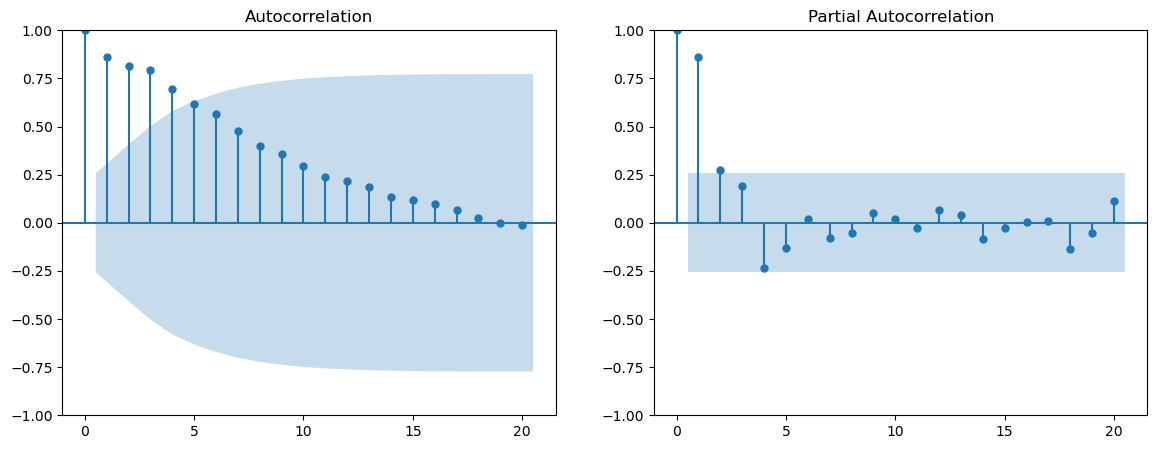

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['Exports'], ax=axes[0], lags=20)

plot_pacf(df['Exports'], ax=axes[1], lags=20, method='ywm')

plt.show()

show a slow decay, indicating a long-term dependence between lagged values. This is a sign that the mean and autocorrelation structure of the series do not change over time.

# Since Engle's test showed non-constant variance, transform data

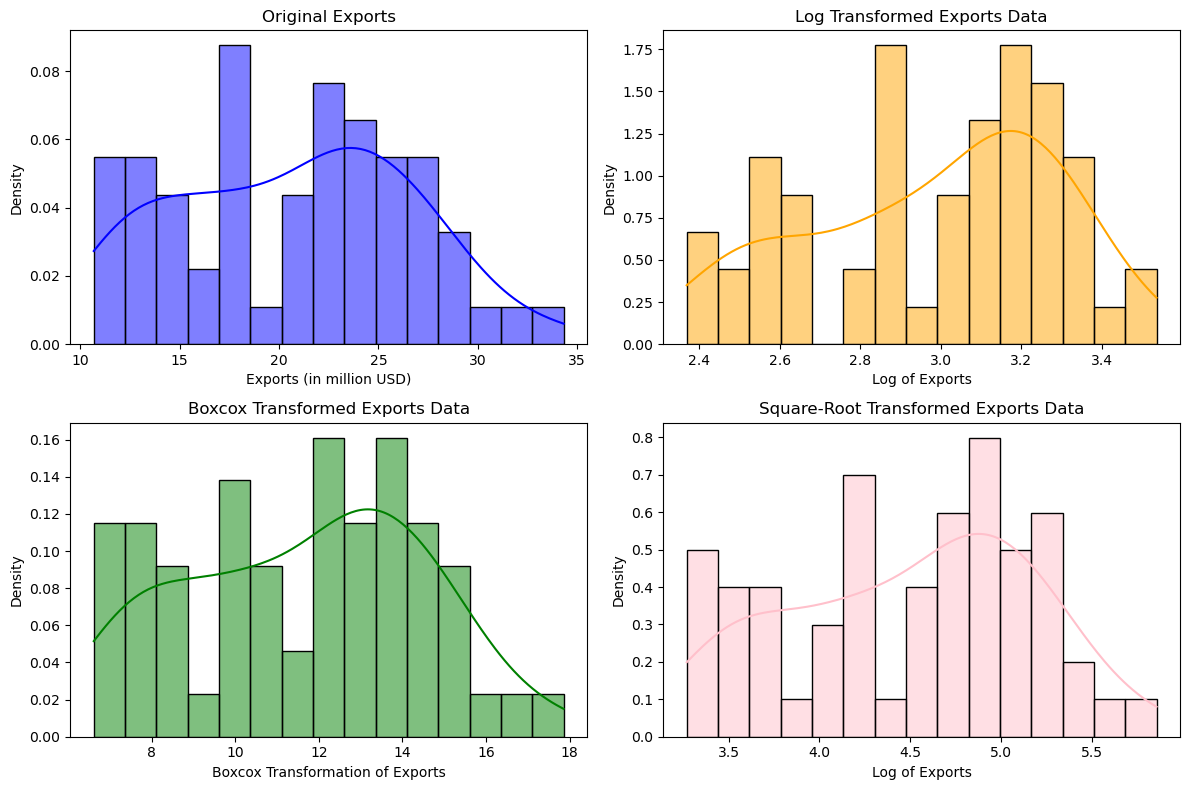

In [9]:

df['Log_Exports'] = np.log(df['Exports'])
df['Sqrt_Exports'] = np.sqrt(df['Exports'])
df['Boxcox_Exports'], fitted_lambda = boxcox(df['Exports'])

plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.histplot(df['Exports'], bins=15, kde=True, stat="density", color='blue')
plt.title('Original Exports')
plt.xlabel('Exports (in million USD)')
plt.ylabel('Density')


# Plot 2
plt.subplot(2, 2, 2)
sns.histplot(df['Log_Exports'], bins=15, kde=True, stat="density", color="orange")
plt.title('Log Transformed Exports Data')
plt.xlabel('Log of Exports')
plt.ylabel('Density')

# Plot 4
plt.subplot(2, 2, 3)
sns.histplot(df['Boxcox_Exports'], bins=15, kde=True, stat="density", color="green")
plt.title('Boxcox Transformed Exports Data')
plt.xlabel('Boxcox Transformation of Exports')
plt.ylabel('Density')

# Plot 3
plt.subplot(2, 2, 4)
sns.histplot(df['Sqrt_Exports'], bins=15, kde=True, stat="density", color="pink")
plt.title('Square-Root Transformed Exports Data')
plt.xlabel('Log of Exports')
plt.ylabel('Density')


plt.tight_layout()  
plt.show()


## Shapiro-Wilks
## H0: Normally Distributed
## HA: Not Normally Distributed

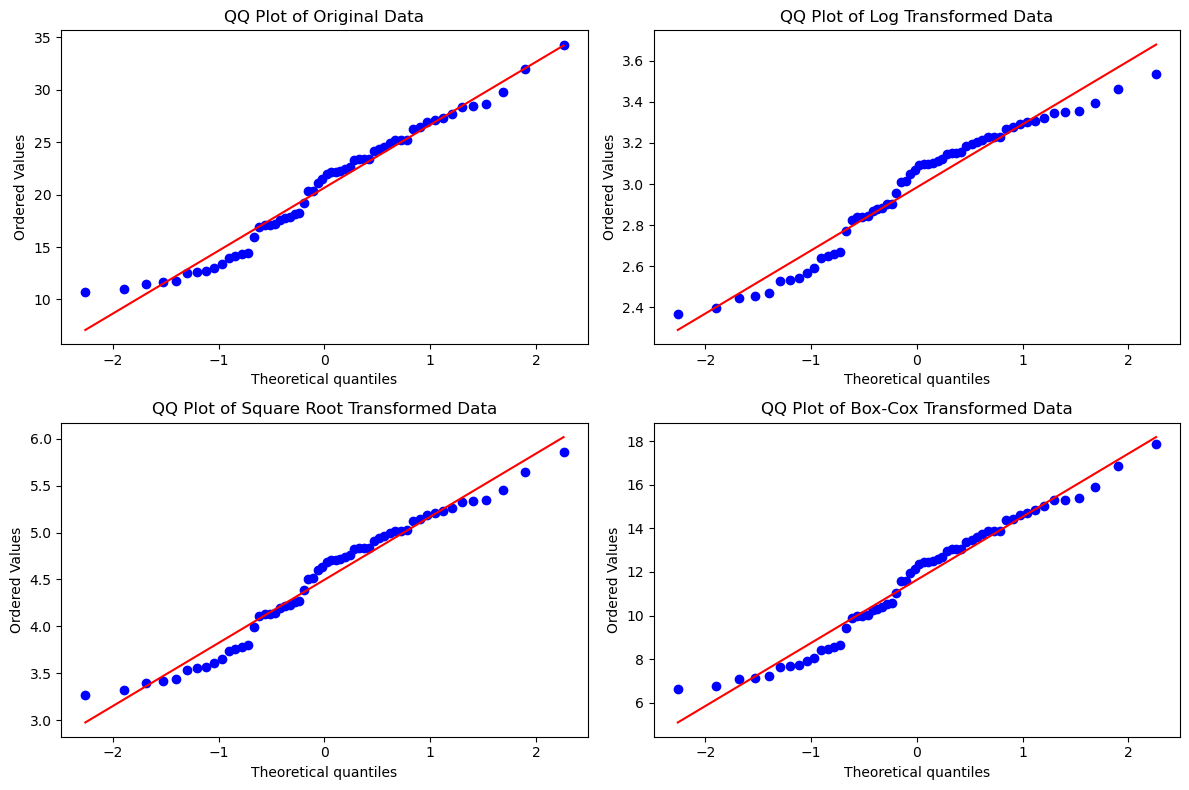

Shapiro-Wilk Test P-value (Original): 0.1145
Shapiro-Wilk Test P-value (Log Transformed): 0.0143
Shapiro-Wilk Test P-value (Sqrt Original): 0.0620
Shapiro-Wilk Test P-value (BoxCox Transformed): 0.0954


In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
stats.probplot(df['Exports'], dist="norm", plot=plt)
plt.title('QQ Plot of Original Data')

plt.subplot(2, 2, 2)
stats.probplot(df['Log_Exports'], dist="norm", plot=plt)
plt.title('QQ Plot of Log Transformed Data')


plt.subplot(2, 2, 3)
stats.probplot(df['Sqrt_Exports'], dist="norm", plot=plt)
plt.title('QQ Plot of Square Root Transformed Data')


plt.subplot(2, 2, 4)
stats.probplot(df['Boxcox_Exports'], dist="norm", plot=plt)
plt.title('QQ Plot of Box-Cox Transformed Data')
plt.tight_layout()  
plt.show()

original_pvalue = stats.shapiro(df['Exports'])[1]
Log_Exports_transformed_pvalue = stats.shapiro(df['Log_Exports'])[1]
Sqrt_Exports_original_pvalue = stats.shapiro(df['Sqrt_Exports'])[1]
Boxcox_Exports_transformed_pvalue = stats.shapiro(df['Boxcox_Exports'])[1]

print(f"Shapiro-Wilk Test P-value (Original): {original_pvalue:.4f}")
print(f"Shapiro-Wilk Test P-value (Log Transformed): {Log_Exports_transformed_pvalue:.4f}")
print(f"Shapiro-Wilk Test P-value (Sqrt Original): {Sqrt_Exports_original_pvalue:.4f}")
print(f"Shapiro-Wilk Test P-value (BoxCox Transformed): {Boxcox_Exports_transformed_pvalue:.4f}")


In [12]:
skewness_comparison = {
    'Original Skewness': df['Exports'].skew(),
    'Log Skewness': df['Log_Exports'].skew(),
    'Square Root Skewness': df['Sqrt_Exports'].skew(),
    'Box-Cox ': df['Boxcox_Exports'].skew()
}

skewness_comparison


{'Original Skewness': 0.03397663478316858,
 'Log Skewness': -0.4174993355111485,
 'Square Root Skewness': -0.1983603589685804,
 'Box-Cox ': -0.08091612000497714}

# Check non-constant variance again

In [13]:
engle_test = het_arch(df['Log_Exports'])
print('Test statistic: ', engle_test[0])
print('P-value: ', engle_test[1])

Test statistic:  41.66822517462835
P-value:  8.589524357208466e-06


In [14]:
engle_test = het_arch(df['Boxcox_Exports'])
print('Test statistic: ', engle_test[0])
print('P-value: ', engle_test[1])

Test statistic:  40.402562590264516
P-value:  1.4390293564865631e-05


# Check Stationarity for all 3:

In [16]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'p-value': result[1]}

series_diff = df['Exports'].diff().dropna()

# Ensure positivity for log transformation
series_log = np.log(df['Exports'] - df['Exports'].min() + 1)  # Adjust to ensure all values are positive for log
series_log_diff = series_log.diff().dropna()

# Ensure positivity for Box-Cox transformation and apply difference
shifted_series = df['Exports'] - df['Exports'].min() + 1  # Adjust to ensure positivity for Box-Cox
series_boxcox, _ = boxcox(shifted_series)
series_boxcox_diff = pd.Series(series_boxcox).diff().dropna()

# Apply ADF test to each differenced series
adf_results_corrected = {
    'Original First-Difference p-value': adf_test(series_diff),
    'Log Difference p-value': adf_test(df['Log_Exports'].diff().dropna()),
    'BoxCox Difference p-value': adf_test(df['Boxcox_Exports'].diff().dropna())
}

adf_results_corrected


{'Original First-Difference p-value': {'p-value': 0.00026339432031339437},
 'Log Difference p-value': {'p-value': 0.0006794976404052878},
 'BoxCox Difference p-value': {'p-value': 0.00034303595823210006}}

# Take First Difference of BoxCox to Assess Stationarity

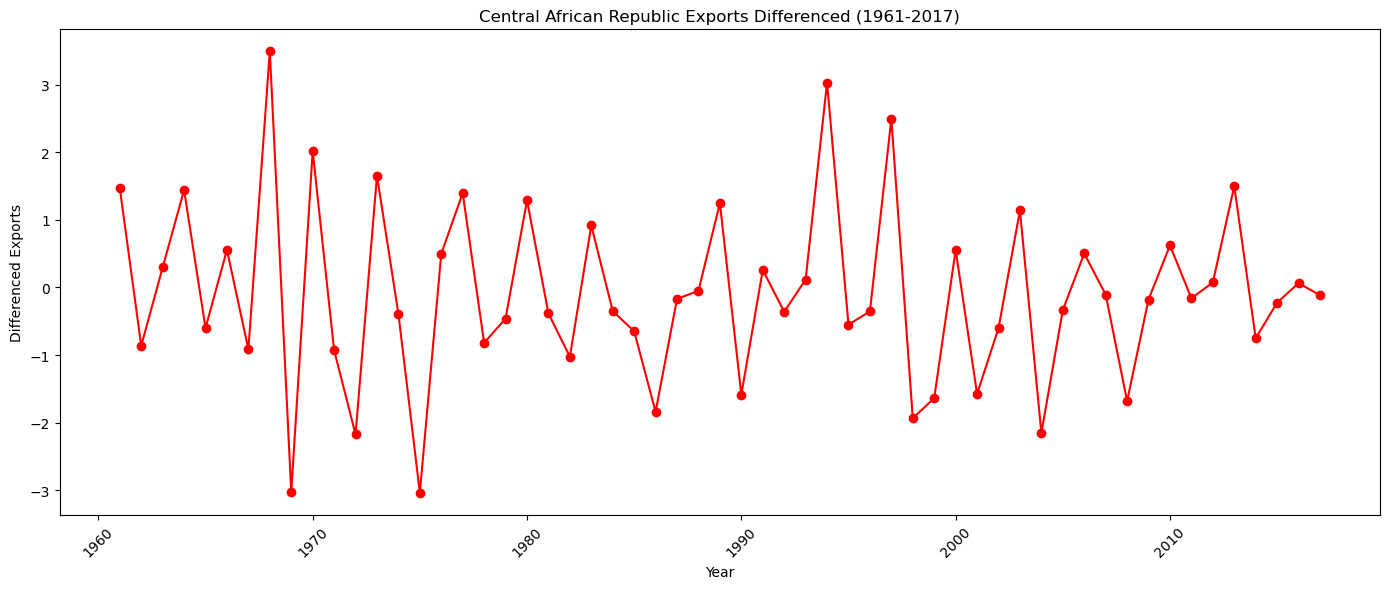

In [17]:
df['Boxcox_Diff'] = df['Boxcox_Exports'].diff()
df_boxcox_diff = df.dropna(subset=['Boxcox_Diff']).reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.plot(df_boxcox_diff['Year'], df_boxcox_diff['Boxcox_Diff'], marker='o', linestyle='-', color='r')
plt.title('Central African Republic Exports Differenced (1961-2017)')
plt.xlabel('Year')
plt.ylabel('Differenced Exports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
exports_summary = df_boxcox_diff['Boxcox_Diff'].describe()


In [18]:
adf_test_diff_original = adfuller(df_boxcox_diff['Boxcox_Diff'])
print('ADF statistic:', adf_test_diff_original[0])
print('P-value for ADF statistic:', adf_test_diff_original[1])

ADF statistic: -4.364363482043975
P-value for ADF statistic: 0.00034303595823210006


# Take First Difference of Log to Assess Stationarity

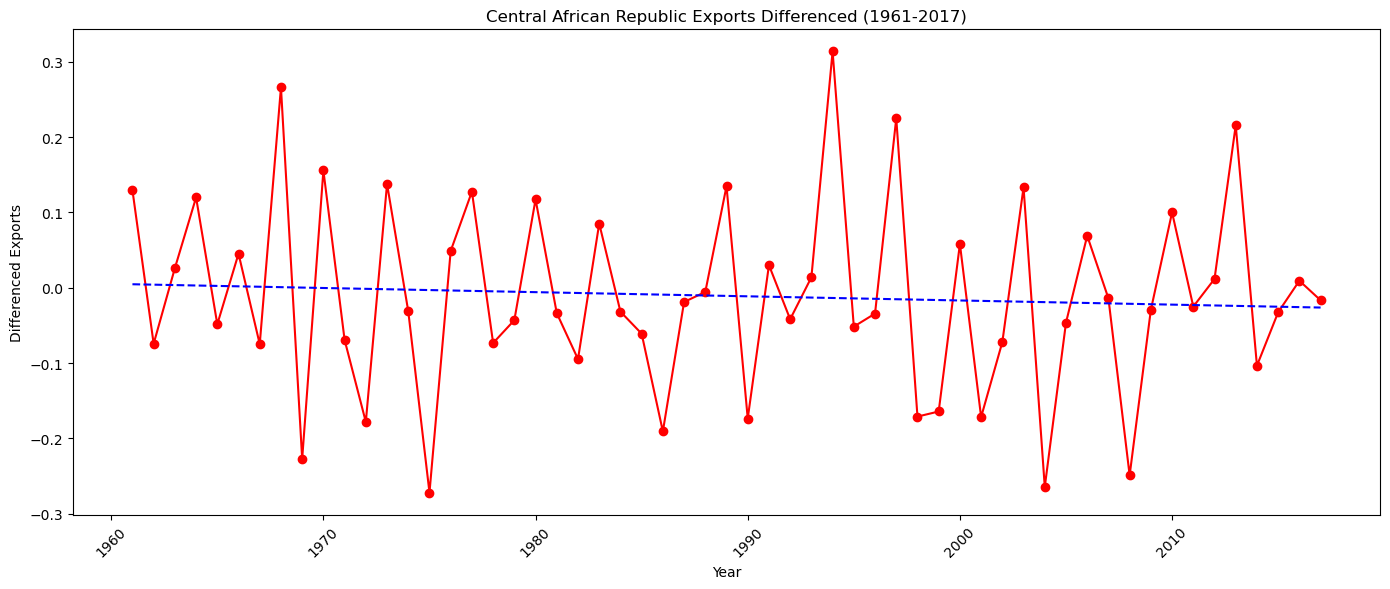

In [20]:
df['Log_Diff'] = df['Log_Exports'].diff()
df_log_diff = df.dropna(subset=['Log_Diff']).reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.plot(df_log_diff['Year'], df_log_diff['Log_Diff'], marker='o', linestyle='-', color='r')
z = np.polyfit(df_log_diff['Year'], df_log_diff['Log_Diff'], deg=1)
p = np.poly1d(z)
plt.plot(df_log_diff['Year'], p(df_log_diff['Year']), "b--", label='Trend Line')  # Add the trend line plot
plt.title('Central African Republic Exports Differenced (1961-2017)')
plt.xlabel('Year')
plt.ylabel('Differenced Exports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
exports_summary = df_log_diff['Log_Diff'].describe()


In [21]:
adf_test_diff_original = adfuller(df_log_diff['Log_Diff'])
print('ADF statistic:', adf_test_diff_original[0])
print('P-value for ADF statistic:', adf_test_diff_original[1])

ADF statistic: -4.192095316398539
P-value for ADF statistic: 0.0006794976404052878


# Take First Difference of Original to Assess Stationarity

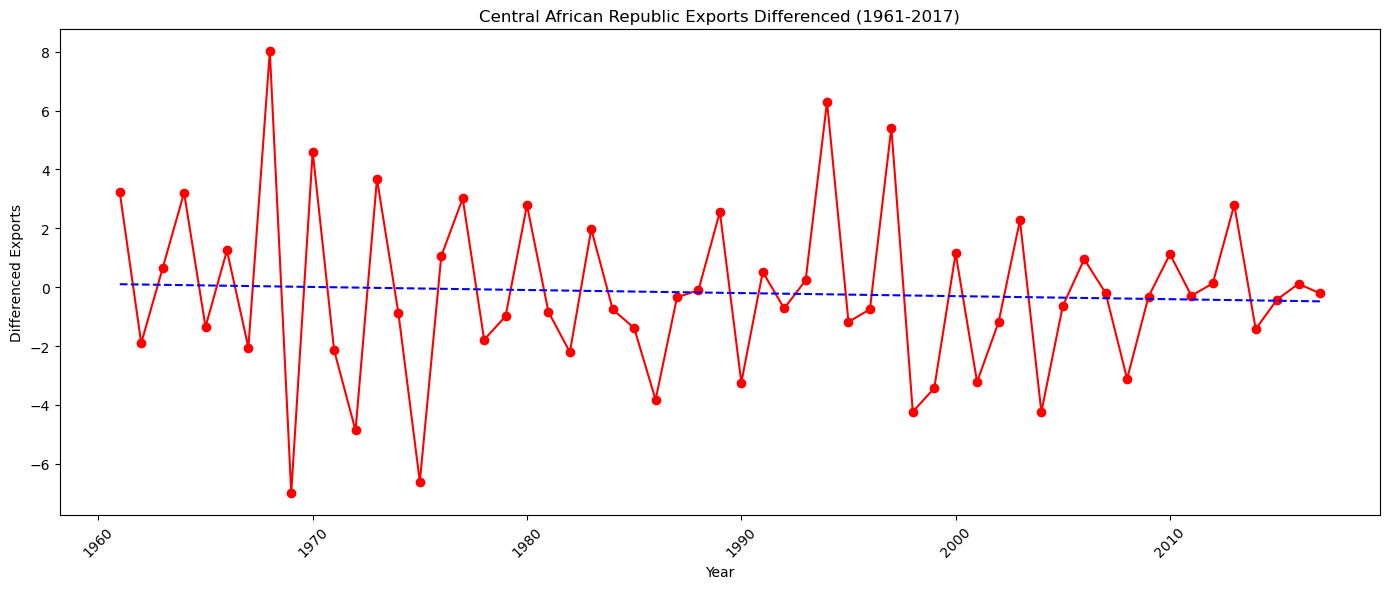

In [22]:
df['Original_Diff'] = df['Exports'].diff()
df_original_diff = df.dropna(subset=['Original_Diff']).reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.plot(df_original_diff['Year'], df_original_diff['Original_Diff'], marker='o', linestyle='-', color='r')
z = np.polyfit(df_original_diff['Year'], df_original_diff['Original_Diff'], deg=1)
p = np.poly1d(z)
plt.plot(df_original_diff['Year'], p(df_original_diff['Year']), "b--", label='Trend Line')  # Add the trend line plot

plt.title('Central African Republic Exports Differenced (1961-2017)')
plt.xlabel('Year')
plt.ylabel('Differenced Exports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
exports_summary = df_original_diff['Original_Diff'].describe()

In [23]:
adf_test_diff_original = adfuller(df_original_diff['Original_Diff'])
print('ADF statistic:', adf_test_diff_original[0])
print('P-value for ADF statistic:', adf_test_diff_original[1])

ADF statistic: -4.42923859757683
P-value for ADF statistic: 0.00026339432031339437


# Confirm Constant Variance

In [24]:
engle_test = het_arch(df_original_diff['Original_Diff'])
print('Test statistic: ', engle_test[0])
print('P-value: ', engle_test[1])

Test statistic:  15.518104501841464
P-value:  0.11428329745370651


In [25]:
engle_test = het_arch(df_boxcox_diff['Boxcox_Diff'])
print('Test statistic: ', engle_test[0])
print('P-value: ', engle_test[1])

Test statistic:  13.649820666883011
P-value:  0.1895717965170068


# Plot ACF and PACF to select best p and q values

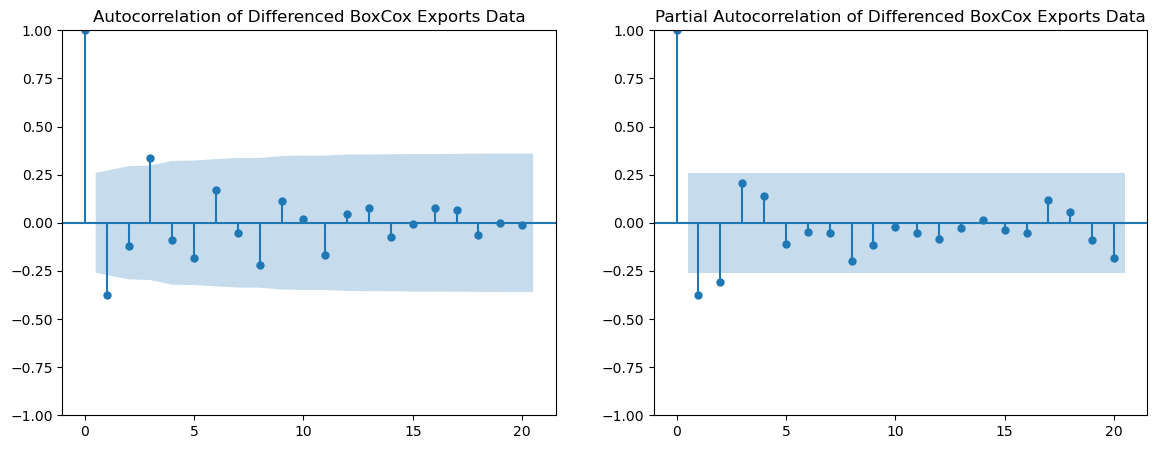

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_boxcox_diff['Boxcox_Diff'], ax=axes[0], lags=20, title =  'Autocorrelation of Differenced BoxCox Exports Data')

plot_pacf(df_boxcox_diff['Boxcox_Diff'], ax=axes[1], lags=20, method='ywm', title = 'Partial Autocorrelation of Differenced BoxCox Exports Data')

plt.show()


# Fit various p and q models and find those with lowest AIC and BIC
## This is fitting onto the entire dataset, no train-test split

In [27]:
p_range = range(0, 4)  # AR terms
q_range = range(0, 4)  # MA terms

pqd_combinations = list(itertools.product(p_range, [0], q_range))

aic_scores_dict = {}
bic_scores_dict = {}

for combination in pqd_combinations:
    try:
        model = ARIMA(df_original_diff['Original_Diff'], order=combination)
        model_fit = model.fit()
        
        aic_scores_dict[combination] = model_fit.aic
        bic_scores_dict[combination] = model_fit.bic

    except:
        continue

aic_scores_dict

best_arima = pd.DataFrame(list(aic_scores_dict.items()), columns=['Combination', 'AIC: Non-Transformed Difference Data'])
best_arima.sort_values('AIC: Non-Transformed Difference Data').head(15)



/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/arya/anaconda3/lib/python3

,Combination,AIC: Non-Transformed Difference Data
11,"(2, 0, 3)",274.942599
14,"(3, 0, 2)",275.117325
12,"(3, 0, 0)",275.179853
8,"(2, 0, 0)",275.253517
15,"(3, 0, 3)",275.297676
10,"(2, 0, 2)",275.377847
3,"(0, 0, 3)",275.796723
9,"(2, 0, 1)",276.284892
13,"(3, 0, 1)",276.710022
1,"(0, 0, 1)",276.820924


In [28]:
model_200 = ARIMA(df_boxcox_diff['Boxcox_Diff'], order=(2,0,0))
model_200_fit = model_200.fit()
results_summary = model_200_fit.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Boxcox_Diff   No. Observations:                   57
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -90.326
Date:                Sat, 16 Mar 2024   AIC                            188.652
Time:                        22:51:20   BIC                            196.825
Sample:                             0   HQIC                           191.828
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1044      0.098     -1.069      0.285      -0.296       0.087
ar.L1         -0.4943      0.160     -3.094      0.002      -0.807      -0.181
ar.L2         -0.3050      0.156     -1.955      0.051      -0.611       0.001
sigma2         1.3845      0.246      5.627      0.000       0.902       1.867
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.63   Prob(JB):                         0.16
Heteroskedasticity (H):               0.47   Skew:                             0.52
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model_203 = ARIMA(df_boxcox_diff['Boxcox_Diff'], order=(2,0,3))
model_203_fit = model_203.fit()
results_summary = model_203_fit.summary()
results_summary

/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Boxcox_Diff   No. Observations:                   57
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 -87.023
Date:                Sat, 16 Mar 2024   AIC                            188.046
Time:                        22:51:20   BIC                            202.347
Sample:                             0   HQIC                           193.604
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1064      0.113     -0.943      0.346      -0.328       0.115
ar.L1         -0.6633      0.068     -9.685      0.000      -0.797      -0.529
ar.L2         -0.9757      0.066    -14.736      0.000      -1.106      -0.846
ma.L1          0.2768      1.183      0.234      0.815      -2.043       2.596
ma.L2          0.8376      3.858      0.217      0.828      -6.724       8.399
ma.L3         -0.2836      1.257     -0.226      0.822      -2.748       2.180
sigma2         1.1485      4.728      0.243      0.808      -8.118      10.415
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.89   Prob(JB):                         0.41
Heteroskedasticity (H):               0.40   Skew:                             0.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 1000x400 with 0 Axes>

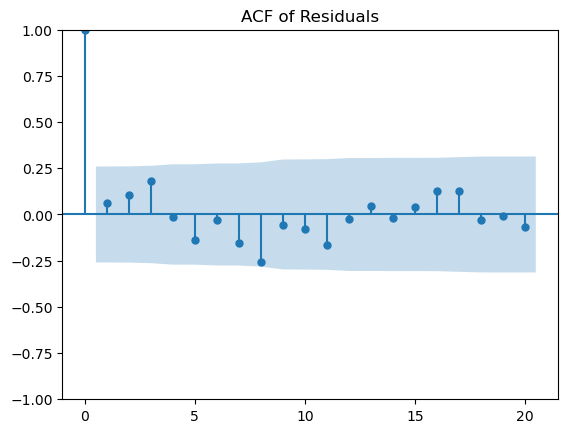

Portmanteau (Ljung-Box) Test Results:
Lag   Test Statistics   P-value
1     0.2185             0.6402
2     0.9295             0.6283
3     2.9230             0.4036
4     2.9324             0.5692
5     4.1263             0.5314
6     4.1812             0.6522
7     5.7544             0.5687
8     10.3119            0.2438
9     10.5390            0.3086
10    10.9948            0.3579

The residuals look like white noise.


In [31]:
plt.figure(figsize=(10, 4))

residuals = model_200_fit.resid

plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

lags = min(10, len(residuals)//5)  # Setting maximum lags to 10 or 1/5th of data
lb_test = acorr_ljungbox(residuals, lags=lags)
lb_test

test_statistics = lb_test['lb_stat'] 
p_values = lb_test['lb_pvalue'] 

print("Portmanteau (Ljung-Box) Test Results:")
print("Lag   Test Statistics   P-value")
for i in range(len(p_values)):
    print(f"{i+1: <6}{test_statistics.iloc[i]: <18.4f}{p_values.iloc[i]: .4f}")

alpha = 0.05  
if all(p_values > alpha):
    print("\nThe residuals look like white noise.")
else:
    print("\nThe residuals do not look like white noise.")


<Figure size 1000x400 with 0 Axes>

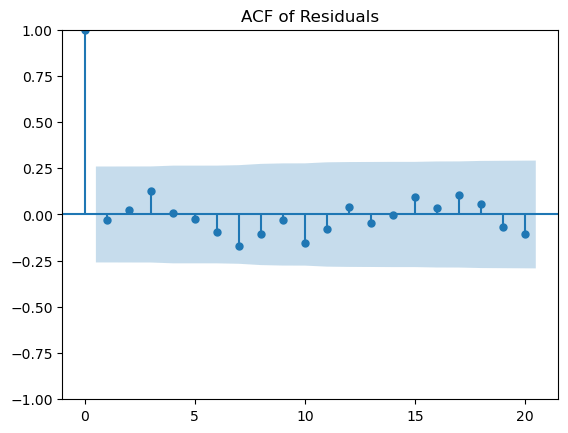

Portmanteau (Ljung-Box) Test Results:
Lag   Test Statistics   P-value
1     0.0468             0.8287
2     0.0899             0.9561
3     1.1339             0.7689
4     1.1367             0.8884
5     1.1768             0.9471
6     1.7880             0.9381
7     3.6848             0.8153
8     4.4165             0.8177
9     4.4887             0.8764
10    6.1513             0.8024

The residuals look like white noise.


In [32]:
plt.figure(figsize=(10, 4))

residuals = model_203_fit.resid

plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

lags = min(10, len(residuals)//5)  # Setting maximum lags to 10 or 1/5th of data
lb_test = acorr_ljungbox(residuals, lags=lags)
lb_test

test_statistics = lb_test['lb_stat'] 
p_values = lb_test['lb_pvalue'] 

print("Portmanteau (Ljung-Box) Test Results:")
print("Lag   Test Statistics   P-value")
for i in range(len(p_values)):
    print(f"{i+1: <6}{test_statistics.iloc[i]: <18.4f}{p_values.iloc[i]: .4f}")

alpha = 0.05  
if all(p_values > alpha):
    print("\nThe residuals look like white noise.")
else:
    print("\nThe residuals do not look like white noise.")


# FORECASTING
## Create train-test split of 80-20

In [33]:
from math import sqrt

train_size = int(len(df) * 0.8)
train =df_boxcox_diff['Boxcox_Diff'][:train_size]
test = df_boxcox_diff['Boxcox_Diff'][train_size:]

model203 = ARIMA(train, order=(2,0,3))
model203_fit = model203.fit()

# Forecast
forecasts_203 = model203_fit.forecast(steps=len(test))

rmse = sqrt(mean_squared_error(test, forecasts_203))
rmse

0.7606958326759313

In [35]:
from math import sqrt

model200 = ARIMA(train, order=(2,0,0))
model200_fit = model200.fit()

# Forecast
forecasts_200 = model200_fit.forecast(steps=len(test))

rmse = sqrt(mean_squared_error(test, forecasts_200))
rmse

0.743366668710872

In [36]:
from math import log, exp
import numpy as np

last_original_value = df_boxcox_diff['Boxcox_Exports'][train_size-1]
cumulative_sum = np.cumsum(forecasts_203)  # cumulative sum of forecasts
forecasts_reverted_diff = last_original_value + cumulative_sum

original_scale_forecasts203 = inv_boxcox(forecasts_reverted_diff, fitted_lambda)

original_scale_forecasts203

46    13.268006
47    12.628640
48    13.403371
49    12.809407
50    12.080521
51    12.536000
52    12.250098
53    11.559460
54    11.750509
55    11.631308
56    11.037612
Name: predicted_mean, dtype: float64

In [37]:
cumulative_sum = np.cumsum(forecasts_200)  # cumulative sum of forecasts
forecasts_reverted_diff = last_original_value + cumulative_sum

original_scale_forecasts200 = inv_boxcox(forecasts_reverted_diff, fitted_lambda)

original_scale_forecasts200

46    13.622383
47    13.300821
48    13.286097
49    13.003267
50    12.767692
51    12.590073
52    12.369935
53    12.155815
54    11.952972
55    11.744101
56    11.536546
Name: predicted_mean, dtype: float64

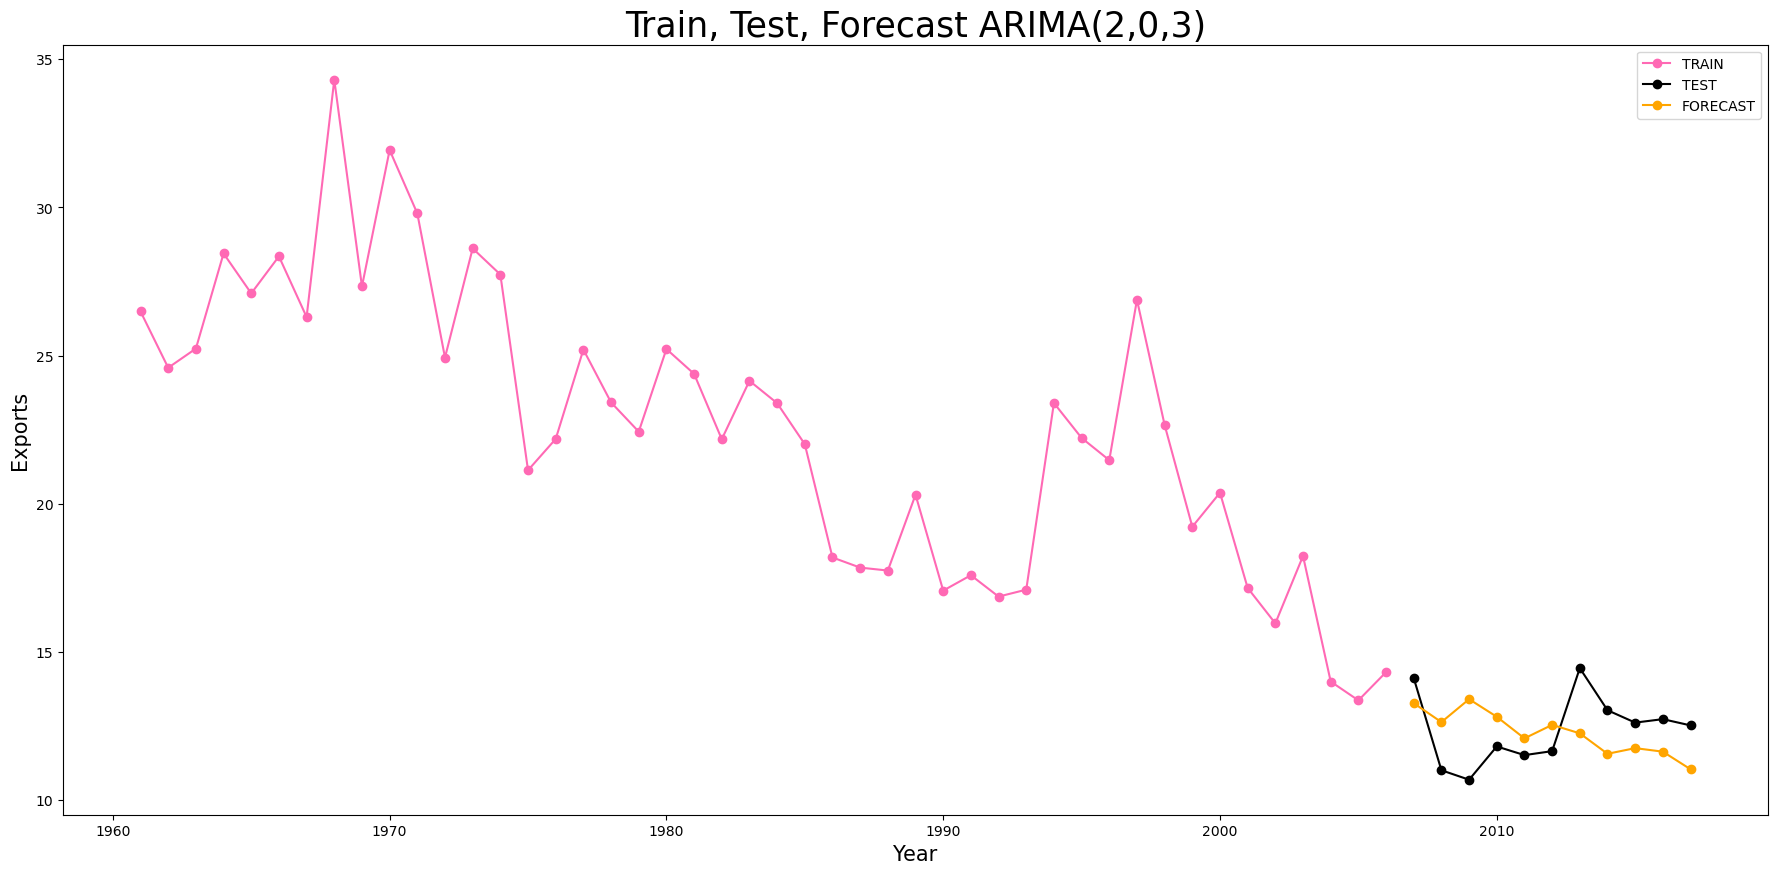

In [39]:
plt.figure(figsize=(22, 10))
plt.plot(df_boxcox_diff['Year'][:train_size], df_boxcox_diff['Exports'][:train_size], color='hotpink', label='TRAIN', marker='o', linestyle='-',)
plt.plot(df_boxcox_diff['Year'][train_size:], df_boxcox_diff['Exports'][train_size:], color='black', label='TEST', marker='o', linestyle='-',)
plt.plot(df_boxcox_diff['Year'][train_size:], original_scale_forecasts203, color='orange', label='FORECAST', marker='o', linestyle='-',)
plt.legend(loc='best')
plt.title('Train, Test, Forecast ARIMA(2,0,3)', fontsize = 25)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Exports', fontsize = 15)

plt.show()

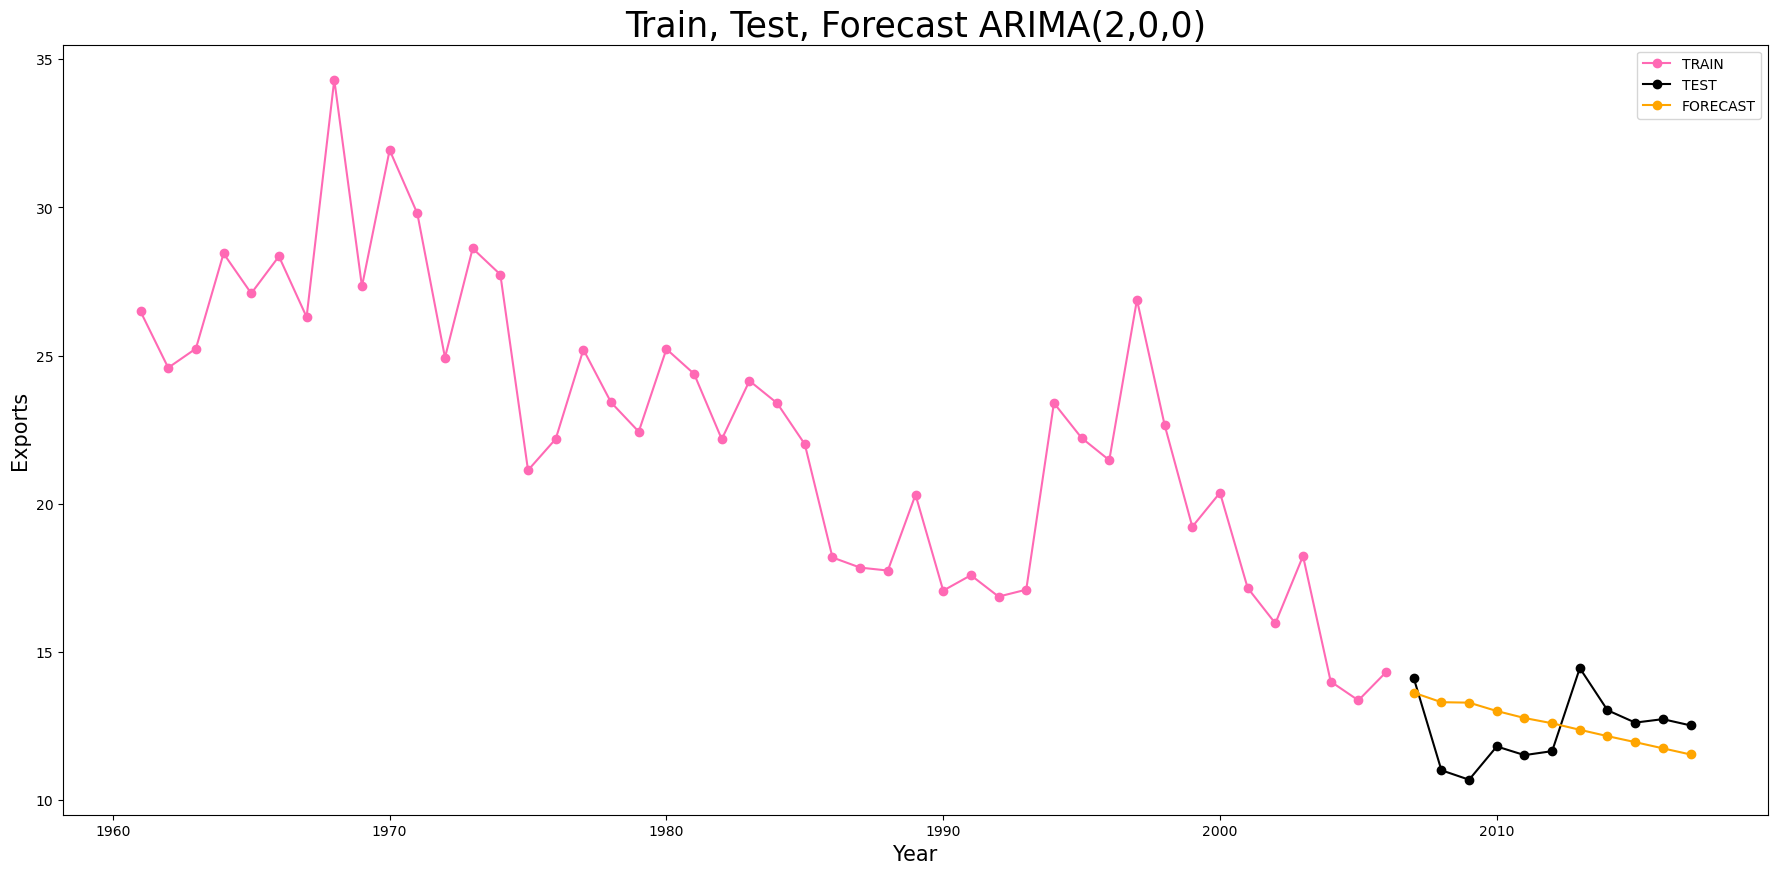

In [40]:
plt.figure(figsize=(22, 10))
plt.plot(df_boxcox_diff['Year'][:train_size], df_boxcox_diff['Exports'][:train_size], color='hotpink', label='TRAIN', marker='o', linestyle='-',)
plt.plot(df_boxcox_diff['Year'][train_size:], df_boxcox_diff['Exports'][train_size:], color='black', label='TEST', marker='o', linestyle='-',)
plt.plot(df_boxcox_diff['Year'][train_size:], original_scale_forecasts200, color='orange', label='FORECAST', marker='o', linestyle='-',)
plt.legend(loc='best')
plt.title('Train, Test, Forecast ARIMA(2,0,0)', fontsize = 25)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Exports', fontsize = 15)
plt.show()

In [43]:
from math import sqrt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = ARIMA(df_boxcox_diff['Boxcox_Diff'], order=(2,0,3))
model_fit = model.fit()

n_forecasts = 10  
forecasts = model_fit.forecast(steps=n_forecasts, alpha = 0.05)

last_original_value = 7.621386

cumulative_sum = np.cumsum(forecasts) 
forecasts_reverted_diff = last_original_value + cumulative_sum

original_scale_forecasts = inv_boxcox(forecasts_reverted_diff, fitted_lambda)
original_scale_forecasts


model_fit.summary()

/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arya/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Boxcox_Diff   No. Observations:                   57
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 -87.023
Date:                Sat, 16 Mar 2024   AIC                            188.046
Time:                        22:53:26   BIC                            202.347
Sample:                             0   HQIC                           193.604
                                 - 57                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1064      0.113     -0.943      0.346      -0.328       0.115
ar.L1         -0.6633      0.068     -9.685      0.000      -0.797      -0.529
ar.L2         -0.9757      0.066    -14.736      0.000      -1.106      -0.846
ma.L1          0.2768      1.183      0.234      0.815      -2.043       2.596
ma.L2          0.8376      3.858      0.217      0.828      -6.724       8.399
ma.L3         -0.2836      1.257     -0.226      0.822      -2.748       2.180
sigma2         1.1485      4.728      0.243      0.808      -8.118      10.415
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.89   Prob(JB):                         0.41
Heteroskedasticity (H):               0.40   Skew:                             0.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

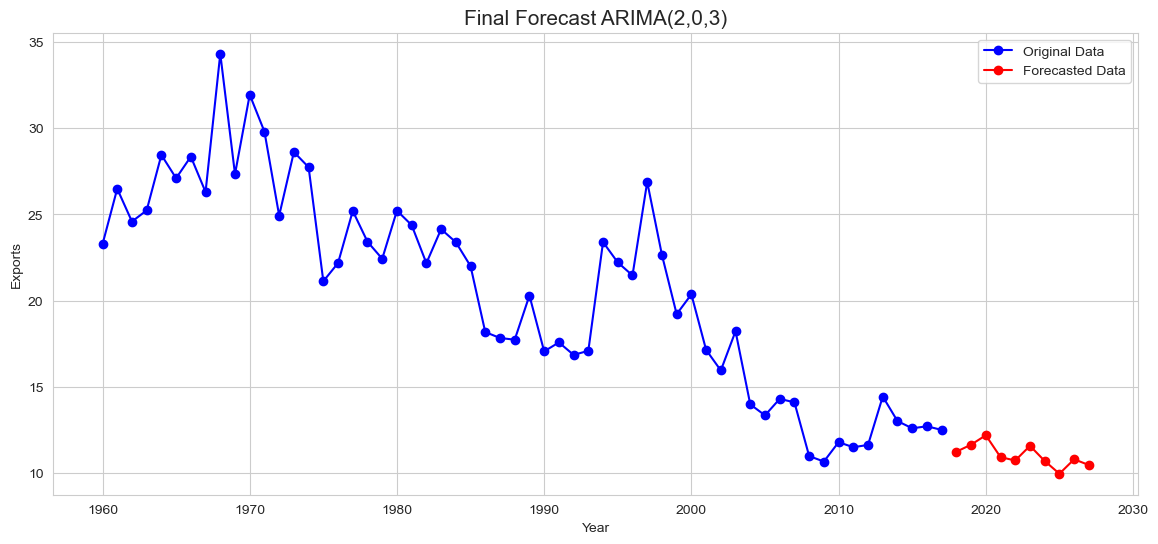

In [45]:
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Exports'], marker='o', linestyle='-', color='b', label='Original Data')
future_years = range(df['Year'].iloc[-1] + 1, df['Year'].iloc[-1] + 1 + len(forecasts))

# Plotting the forecasted values
plt.plot(future_years, original_scale_forecasts, marker='o', linestyle='-', color='r', label='Forecasted Data')
plt.title('Final Forecast ARIMA(2,0,3)', fontsize = 15)
plt.xlabel('Year', fontsize = 10)
plt.ylabel('Exports', fontsize = 10)
plt.legend()
